In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, pacf
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from copy import deepcopy
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.random.seed(123456)

In [2]:
data = pd.read_csv('BTC-USD.csv')

# Data Cleaning

In [3]:
data = data.dropna()
data['Date'] = pd.to_datetime(data['Date'])
data['Volume'] = data['Volume'].astype('int32')
data.set_index('Date', drop = True, inplace = True)

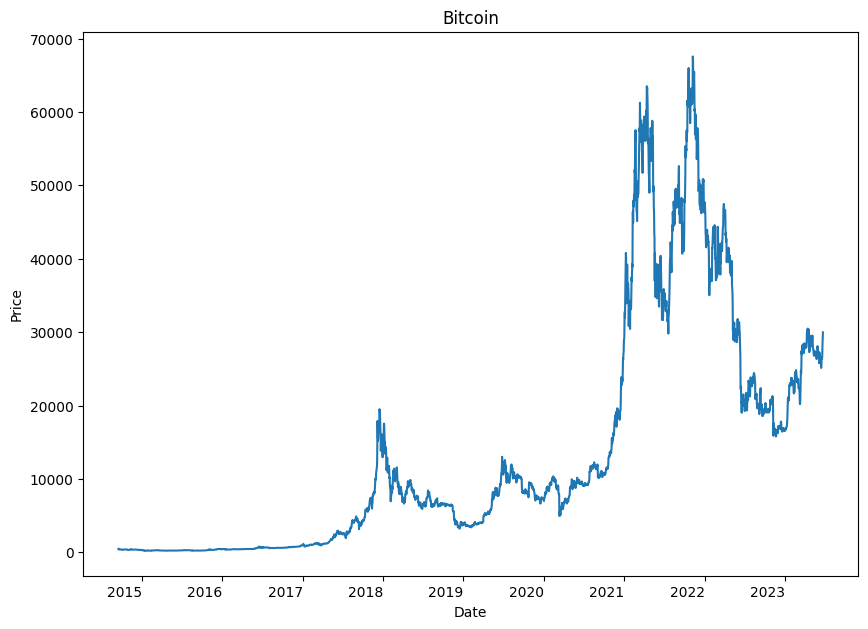

In [4]:
plt.figure(figsize = (10, 8))
data.Close.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin')
plt.xticks(rotation = 0)
plt.show()

# Autocorrelation function
### detect if bitcoin is nonstationary

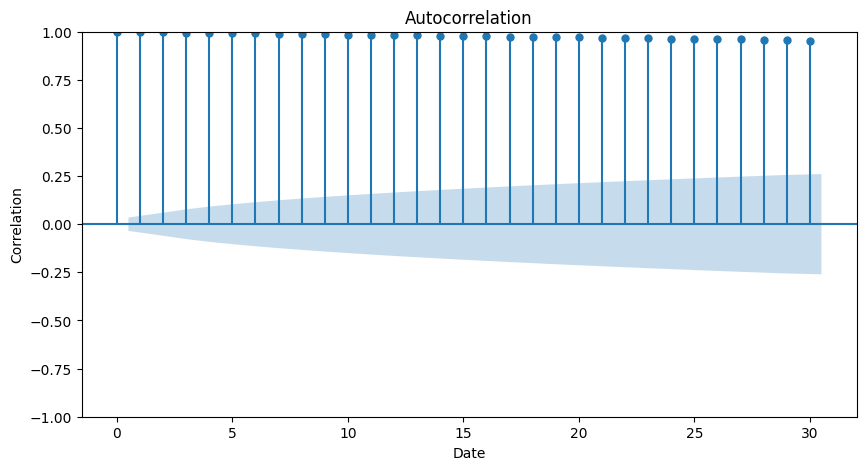

In [5]:
fig, axes = plt.subplots(figsize = (10, 5))
plot_acf(data.Close, axes, lags = 30)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

# Create difference column getting stationary data
$$p = \frac{t_n - t_{n-1}}{t_{n-1}}$$

In [6]:
data['diffs'] = (data.Close.diff() / data.Close.shift(periods = 1, fill_value = 0)).fillna(0)

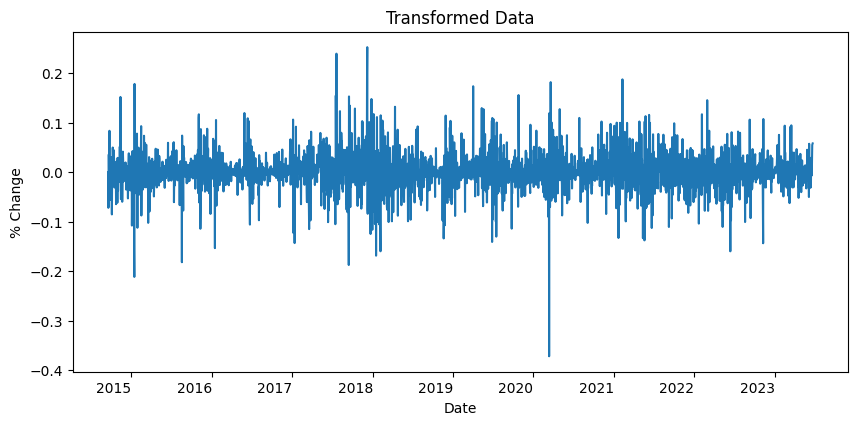

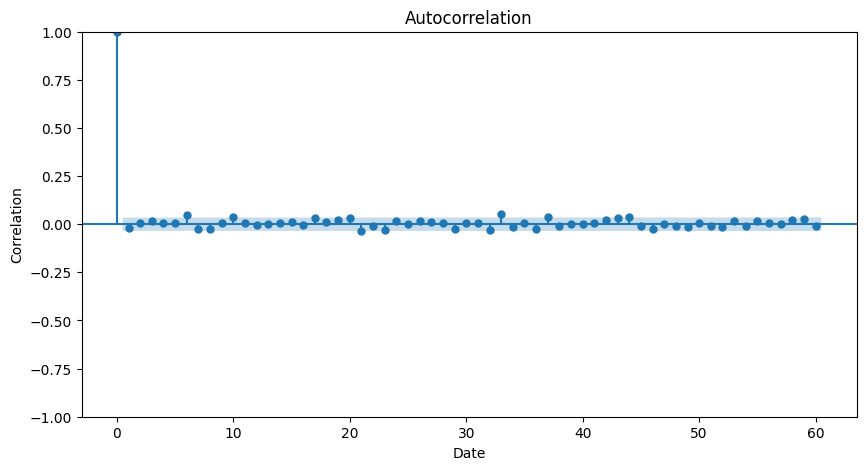

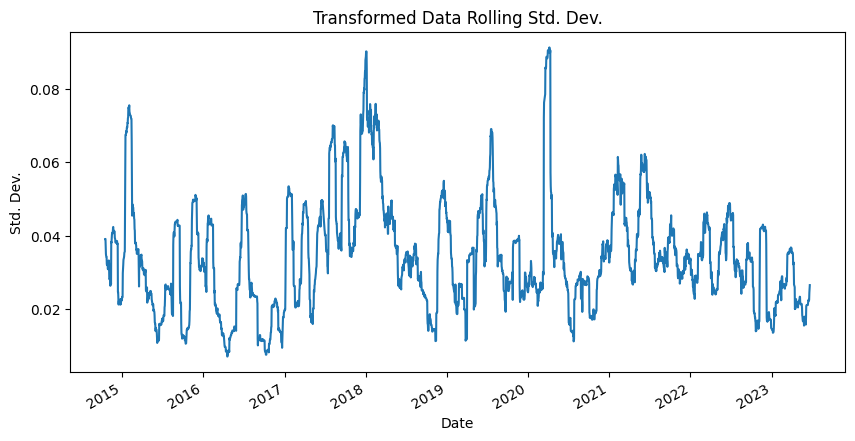

In [7]:
plt.figure(figsize = (10, 5))
data.diffs.plot()
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('Transformed Data')
plt.xticks(rotation = 0)
plt.show()

fig, axes = plt.subplots(figsize = (10, 5))
plot_acf(data.diffs, axes, lags = 60)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()

plt.figure(figsize = (10, 5))
data.diffs.rolling(30).std().plot()
plt.xlabel('Date')
plt.ylabel('Std. Dev.')
plt.title('Transformed Data Rolling Std. Dev.')
plt.show()

# Create target
### percentage change as target

In [54]:
diffs = (data.Close.diff() / data.Close.shift(periods = 1, fill_value = 0)).values[1:]
diffs_len = len(diffs)

# Create features

In [55]:
def Create_X_data(diffs_len, lags):
    diff_data = np.zeros((diffs_len, lags))
    diff_data
    for lag in range(1, lags+1):
        this_data = diffs[: -lag]
        diff_data[lag:, lag-1] = this_data
    return diff_data

In [74]:
x_data = Create_X_data(diffs_len, 20) * 100
x_data = np.around(x_data, decimals = 8)
y_data = diffs * 100
y_data = np.around(y_data, decimals = 8)

# Multi-linear regression
prediction is in terms of % change compared to last day

In [102]:
lr = LinearRegression()
window = 150
preds = np.zeros(diffs_len - window)
for i in range(preds.shape[0] - 1):
    x_train = x_data[i: i + window, :]
    y_train = y_data[i: i + window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i + window + 1, :].reshape(1, -1))
mae = metrics.mean_absolute_error(y_data[window:], preds)
print(f'MSE: {mae:.2f}%')

MSE: 2.77%


# Sharp ratio 
sharp ratio is a way to measure the performance of an investment by taking risk into account not just return.
$$sharp = \frac{E(return) - Rf}{\alpha(return)}$$
_Rf = risk free rate_ <br>
_In this model, risk free rate is assumed as 0_ <br>
Generally speaking, a Sharpe ratio between 1 and 2 is considered good. A ratio between 2 and 3 is very good, and any result higher than 3 is excellent.

# Strategy
The percentage change is represented as buy/sell threshold used in this transaction<br>
If the predicted % change > threshold, buy <br>
If the predicted % change < -threshold, buy <br>

In [103]:
def simulate(data, preds, buy_threshold):
    buy_threshold = buy_threshold
    stake = 100
    actual_price, predicted_price, balances = [], [], []
    buy_price = 0
    buy_points, sell_points = [], []
    balance = 0
    
    start_index = len(data) - len(preds) - 1
    
    for i in range(len(preds)): # 3049
        last_close = data['Close'][i + start_index - 1]
        current_close = data['Close'][i + start_index]
    
        actual_price.append(current_close)
        # predict the exact price for current day
        predicted_price.append(last_close * (1 + preds[i] / 100))
    
        if preds[i] > buy_threshold and buy_price == 0:
            buy_price = actual_price[-1]
            # for plotting
            buy_points.append(i)
    
        elif preds[i] < -buy_threshold and buy_price != 0:
            unit = stake / buy_price
            profit = (current_close - buy_price) * unit
            balance += profit
            buy_price = 0
            # for plotting
            sell_points.append(i)
        balances.append(balance)

    balance_df = pd.DataFrame(balances)
    pct_returns = balance_df.diff() / stake
    pct_returns = pct_returns[pct_returns != 0].dropna()
    sharp = (np.mean(pct_returns) / np.std(pct_returns))

    result = {
        'balance': balance,
        'balances': balances,
        'actual_price': actual_price,
        'buy_price': buy_price,
        'buy_points': buy_points,
        'sell_points': sell_points, 
        'predicted_price': predicted_price, 
        'sharp': sharp
    }
    return result

# Find the best return and threshold

In [104]:
def Best_Tuning(data, preds):
    balance_list = []
    best_rate = 0
    best_return = 0
    
    for i in np.linspace(0, 10, 100):
        s = simulate(data, preds, i)
        balance_list.append(s['balance'])
        if s['balance'] > best_return:
            best_return = s['balance']
            best_rate = i
    result = {
        'balance_list': balance_list, 
        'best_rate': best_rate,
        'best_return': best_return
    }
    return result

Best buy/sell threshold: 5.15%
Highest return: $1,596.14


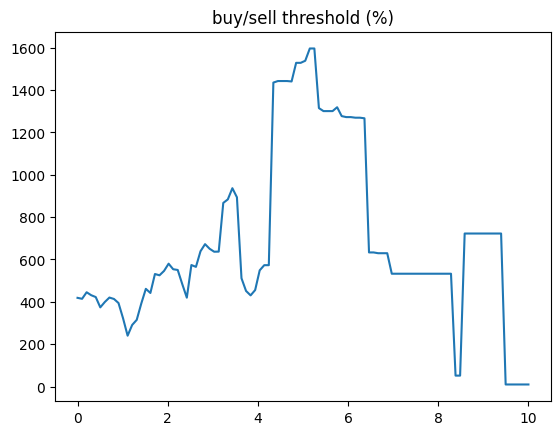

In [105]:
bt = Best_Tuning(data, preds)

print(f"Best buy/sell threshold: {bt['best_rate']:.2f}%")
print(f"Highest return: ${bt['best_return']:,.2f}")
plt.plot(np.linspace(0, 10, 100), bt['balance_list'])

plt.title('buy/sell threshold (%)')
plt.show()

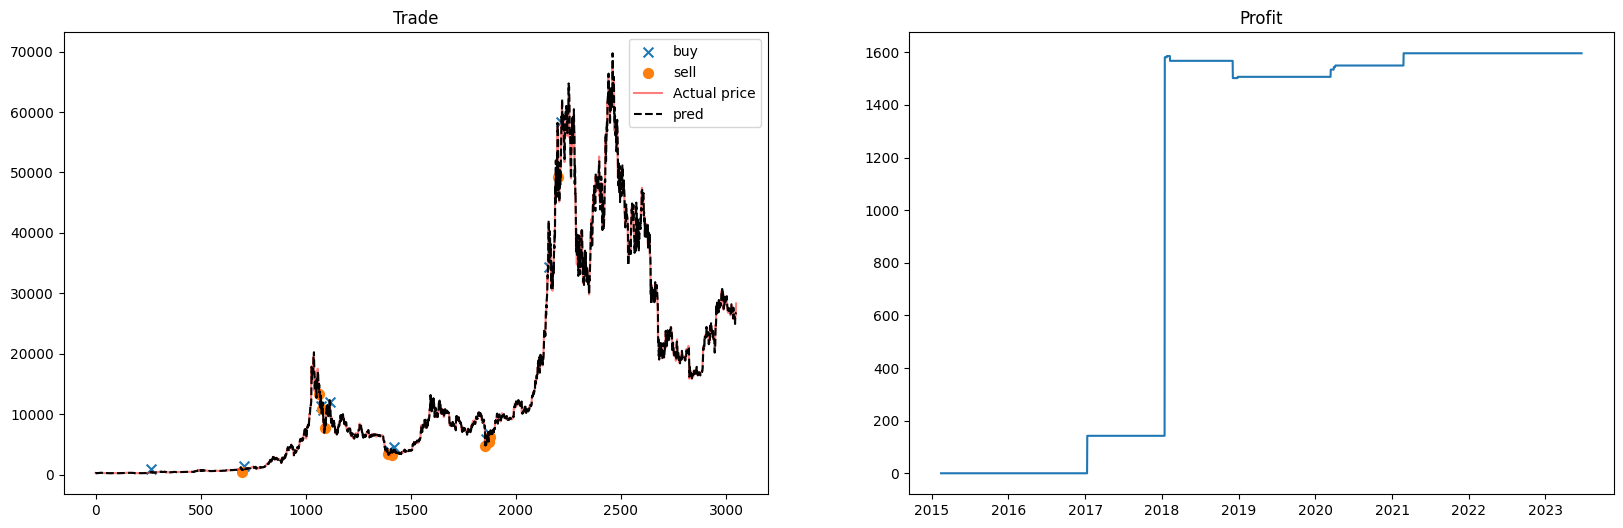

MSE: 2.77
Sharp ratio: 0.37


In [108]:
best_rate = bt['best_rate']
best_model = simulate(data, preds, best_rate)
# for plotting
actual_price = np.array(best_model['actual_price'])
pred = np.array(best_model['predicted_price'])
buy_points = np.array(best_model['buy_points'])
sell_points = np.array(best_model['sell_points'])
balances = np.array(best_model['balances'])
sharp = np.array(best_model['sharp'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
ax1.scatter(buy_points, actual_price[buy_points] + 500, s = 50, marker = 'x', label = 'buy')
ax1.scatter(sell_points, actual_price[sell_points] - 500, s = 50, marker = 'o', label = 'sell')
ax1.plot(actual_price, label = 'Actual price', c = 'red', alpha = 0.5)
ax1.plot(pred, label = 'pred', linestyle = '--', c = 'black')
ax1.set_title('Trade')
ax1.legend()

ax2.plot(data.index[151:], balances)
ax2.set_title('Profit')
plt.show()
print(f"MSE: {metrics.mean_absolute_error(y_data[window:], preds):,.2f}")
print(f"Sharp ratio: {sharp[0]:,.2f}")

# Ensemble learning 
use ensemble learning to improve the mean absolute error of predicted difference

### Hard voting

In [80]:
class VotingRegressor():
    def __init__(self, base_learners):
        self.base_learners = {}
        for name, learner in base_learners:
            self.base_learners[name] = deepcopy(learner)

    def fit(self, x_data, y_data):
        for name in self.base_learners:
            learner = self.base_learners[name]
            learner.fit(x_data, y_data)

    def predict(self, x_data):
        predictions = np.zeros((len(x_data), len(self.base_learners)))
        names = list(self.base_learners.keys())

        for i in range(len(self.base_learners)):
            name = names[i]
            learner = self.base_learners[name]

            preds = learner.predict(x_data)
            predictions[:, i] = preds

        predictions = np.mean(predictions, axis = 1)
        return predictions
        

In [81]:
base_learners = [('SVR', SVR()), 
                 ('LR', LinearRegression()), 
                 ('KNN', KNeighborsRegressor())]

lr = VotingRegressor(base_learners)

x_data = Create_X_data(diffs_len, 20) * 100
x_data = np.around(x_data, decimals = 8)
y_data = diffs * 100
y_data = np.around(y_data, decimals = 8)

window = 150
preds = np.zeros(diffs_len - window)

for i in range(diffs_len - window - 1):
    x_train = x_data[i: i + window, :]
    y_train = y_data[i: i + window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i + window + 1, :].reshape(1, -1))
print(f'MSE: {metrics.mean_squared_error(y_data[window:], preds):,.2f}')

MSE: 14.60


In [82]:
bt = Best_Tuning(data, preds)
best_return = bt['best_return']
best_rate = bt['best_rate']
balance_list = bt['balance_list']

Best buy/sell threshold: 2.22%
Highest return: $1,798.07


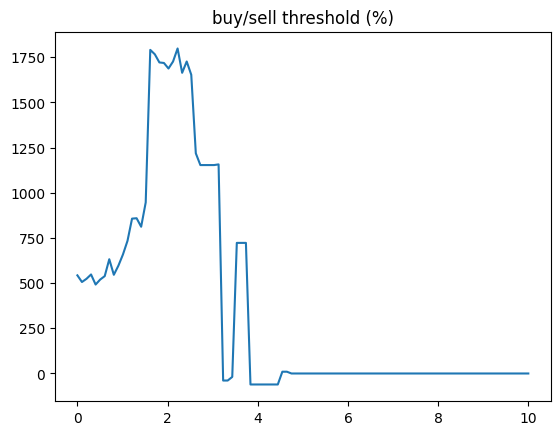

In [83]:
print(f"Best buy/sell threshold: {bt['best_rate']:.2f}%")
print(f"Highest return: ${bt['best_return']:,.2f}")

plt.plot(np.linspace(0, 10, 100), bt['balance_list'])
plt.title('buy/sell threshold (%)')
plt.show()

In [89]:
ensemble_perf = simulate(data, preds, best_rate)

In [101]:
print(f'MSE: {metrics.mean_absolute_error(y_data[window:], preds)}')
print(f"Sharp ratio: {ensemble_perf['sharp'][0]:,.2f}")

MSE: 2.557826012107941
Sharp ratio: 0.38


In [131]:
summary = pd.DataFrame({'ML model': ['Linear Regression', 'Hard Voting'], 
                        'sharp': [0.37, 0.38], 
                        'total revenue': [1596.14, 1798.07], 
                        'buy/sell threshold': ['5.15%', '2.22%']})
summary

,ML model,sharp,total revenue,buy/sell threshold
0,Linear Regression,0.37,1596.14,5.15%
1,Hard Voting,0.38,1798.07,2.22%


By using hard voting ensemble learning, it can increase 0.01 sharp ratio and $200 total revenue